In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/precog-assignment/data-2.csv
/kaggle/input/precog-assignment/state_time.png
/kaggle/input/precog-assignment/state_cases.png
/kaggle/input/precog-assignment/Judge_Act_merge.csv
/kaggle/input/precog-assignment/judges_clean/judges_clean.csv
/kaggle/input/precog-assignment/acts_sections/acts_sections.csv
/kaggle/input/precog-assignment/cases/cases_2015.csv
/kaggle/input/precog-assignment/cases/cases_2012.csv
/kaggle/input/precog-assignment/cases/cases_2018.csv
/kaggle/input/precog-assignment/cases/cases_2013.csv
/kaggle/input/precog-assignment/cases/cases_2017.csv
/kaggle/input/precog-assignment/cases/cases_2010.csv
/kaggle/input/precog-assignment/cases/cases_2014.csv
/kaggle/input/precog-assignment/cases/cases_2016.csv
/kaggle/input/precog-assignment/cases/cases_2011.csv
/kaggle/input/precog-assignment/keys/type_name_key.csv
/kaggle/input/precog-assignment/keys/cases_district_key.csv
/kaggle/input/precog-assignment/keys/act_key.csv
/kaggle/input/precog-assignment/keys/disp_n

In [12]:
import dask.dataframe as dd
import gc
from datetime import date
import glob

In [13]:
ja_merge = dd.read_csv("../input/precog-assignment/Judge_Act_merge.csv")
ja_merge.head()

,ddl_case_id,ddl_judge_id,act,section,criminal,female_judge
0,01-01-01-201900000022018,5.0,4759.0,1123673.0,1.0,0 nonfemale
1,01-01-01-201900000032017,5.0,4759.0,1123673.0,1.0,0 nonfemale
2,01-01-01-201900000042016,5.0,17353.0,865403.0,1.0,0 nonfemale
3,01-01-01-201900000052018,5.0,4759.0,1123673.0,1.0,0 nonfemale
4,01-01-01-201900000072016,5.0,4759.0,132871.0,1.0,0 nonfemale


In [14]:
case_list = os.path.join("../input/precog-assignment/cases","*.csv")
case_list_csv = glob.glob(case_list)
case_list_csv

['../input/precog-assignment/cases/cases_2015.csv',
 '../input/precog-assignment/cases/cases_2012.csv',
 '../input/precog-assignment/cases/cases_2018.csv',
 '../input/precog-assignment/cases/cases_2013.csv',
 '../input/precog-assignment/cases/cases_2017.csv',
 '../input/precog-assignment/cases/cases_2010.csv',
 '../input/precog-assignment/cases/cases_2014.csv',
 '../input/precog-assignment/cases/cases_2016.csv',
 '../input/precog-assignment/cases/cases_2011.csv']

In [15]:
case_list_csv = [path for path in case_list_csv if int(path.split("/")[4].split("_")[1].split(".")[0]) > 2013]
case_list_csv

['../input/precog-assignment/cases/cases_2015.csv',
 '../input/precog-assignment/cases/cases_2018.csv',
 '../input/precog-assignment/cases/cases_2017.csv',
 '../input/precog-assignment/cases/cases_2014.csv',
 '../input/precog-assignment/cases/cases_2016.csv']

In [16]:
# Dictionaries to store the required values

male_male = {}
male_female = {}
female_female = {}
female_male = {}

In [17]:
def days_elapsed(date1,date2):
    d1s = date1.split("-")
    d2s = date2.split("-")
    d1s = [int(i) for i in d1s]
    d2s = [int(i) for i in d2s]
    d1 = date(d1s[0],d1s[1],d1s[2])
    d2 = date(d2s[0],d2s[1],d2s[2])
    return (d2 - d1).days

In [18]:
for path in case_list_csv:
    
    year_string = int(path.split("/")[4].split("_")[1].split(".")[0])
    
    case_df = dd.read_csv(path,usecols=["ddl_case_id","female_defendant","date_of_filing","date_of_decision"])
    
    merged_df = ja_merge.merge(case_df,on=["ddl_case_id"],how="inner")
    merged_df = merged_df.dropna(subset=["date_of_decision"]).compute()
    
    del case_df
    gc.collect()
        
    merged_df["time_taken"] = merged_df.apply(lambda x: days_elapsed(x["date_of_filing"],x["date_of_decision"]),axis=1)
    merged_df.drop(["ddl_case_id","date_of_filing","date_of_decision","criminal"],axis=1,inplace=True)
    
    merged_df = merged_df[merged_df["female_defendant"] != "-9998 unclear"]
    merged_df = merged_df[merged_df["female_defendant"] != "-9999 missing name"]
    
    merged_df.drop(["ddl_judge_id"],axis=1,inplace=True)
    
    
    grouped_df = merged_df.groupby(["act","section","female_judge","female_defendant"])["time_taken"].mean().reset_index(drop=False)
    
    del merged_df
    gc.collect()
    
    count_df = grouped_df.groupby(["act","section"]).size().reset_index(drop=False,name="size")
    count_df = count_df[count_df["size"] == 4].drop(["size"],axis=1)
    
    pivot_df = grouped_df.merge(count_df,on=["act","section"],how="inner")
    
    del count_df
    gc.collect()
    
    del grouped_df
    gc.collect()
    
    female_female[year_string] = pivot_df[(pivot_df["female_defendant"] == "1 female") & (pivot_df["female_judge"] == "1 female")]["time_taken"].mean()
    female_male[year_string] = pivot_df[(pivot_df["female_defendant"] == "0 male") & (pivot_df["female_judge"] == "1 female")]["time_taken"].mean()
    male_male[year_string] = pivot_df[(pivot_df["female_defendant"] == "0 male") & (pivot_df["female_judge"] == "0 nonfemale")]["time_taken"].mean()
    male_female[year_string] = pivot_df[(pivot_df["female_defendant"] == "1 female") & (pivot_df["female_judge"] == "0 nonfemale")]["time_taken"].mean()
    
    del pivot_df
    gc.collect()

    

In [19]:
print(female_female)
print(female_male)
print(male_male)
print(male_female)

{2015: 481.4755550759002, 2018: 82.71707227848854, 2017: 171.6624176859878, 2014: 648.5489456226362, 2016: 306.1267617384629}
{2015: 468.0055120822087, 2018: 76.153743024715, 2017: 164.12405324683908, 2014: 602.7159801968976, 2016: 304.66953722189317}
{2015: 375.7972441459425, 2018: 68.35259797483455, 2017: 143.52781069727024, 2014: 509.94448265074953, 2016: 250.47591549258033}
{2015: 382.58580304763893, 2018: 69.17490087098811, 2017: 157.21273878507577, 2014: 518.3026595937569, 2016: 264.51712063157214}


In [3]:
import matplotlib.pyplot as plt
from collections import OrderedDict

In [4]:
female_female = {2015: 481.4755550759002, 2018: 82.71707227848854, 2017: 171.6624176859878, 2014: 648.5489456226362, 2016: 306.1267617384629}
female_male = {2015: 468.0055120822087, 2018: 76.153743024715, 2017: 164.12405324683908, 2014: 602.7159801968976, 2016: 304.66953722189317}
male_male = {2015: 375.7972441459425, 2018: 68.35259797483455, 2017: 143.52781069727024, 2014: 509.94448265074953, 2016: 250.47591549258033}
male_female = {2015: 382.58580304763893, 2018: 69.17490087098811, 2017: 157.21273878507577, 2014: 518.3026595937569, 2016: 264.51712063157214}

In [5]:
female_female = OrderedDict(sorted(female_female.items()))
female_male = OrderedDict(sorted(female_male.items()))
male_male = OrderedDict(sorted(male_male.items()))
male_female = OrderedDict(sorted(male_female.items()))

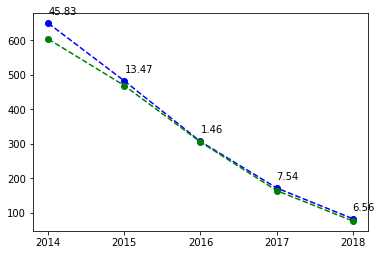

In [13]:
plt.plot(list(female_female.keys()),list(female_female.values()),"--bo")
plt.plot(list(female_male.keys()),list(female_male.values()),"--go")
for i in male_female.keys():
    plt.text(i,y=female_female[i] + 25,s=round(female_female[i]-female_male[i],2))
plt.xticks(list(female_male.keys()))
plt.show()

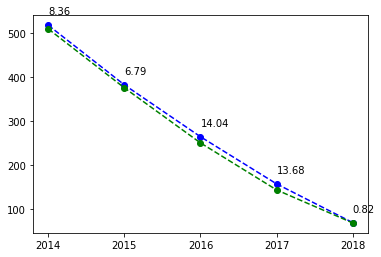

In [14]:
plt.plot(list(male_female.keys()),list(male_female.values()),"--bo")
plt.plot(list(male_male.keys()),list(male_male.values()),"--go")

for i in male_female.keys():
    plt.text(i,y=male_female[i] + 25,s=round(male_female[i]-male_male[i],2))
plt.xticks(list(female_male.keys()))
plt.show()